In [72]:
import tensorflow as tf
import keras
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import ast
import sklearn
from sklearn.utils import class_weight

from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')



In [73]:
#CONSTANTS
tar_path = "/home/shriya/VS-Code-Python/WFLW_images.tar.gz"
extract_path = "/home/shriya/VS-Code-Python/WFLW_images"
csv_path = "/home/shriya/VS-Code-Python/saving.csv"


In [74]:
"""Extracts annotations from a .tar.gz file into a separate path"""
def extract_tar(tar_path, extract_path):
  import tarfile
  import os

    # Ensure the extraction directory exists
  os.makedirs(extract_path, exist_ok=True)

  with tarfile.open(tar_path, "r:gz") as tar:
      # Extract all contents to the specified path
      tar.extractall(path=extract_path)
  print(f"Extracted contents to: {extract_path}")
  image_dir = os.path.join(extract_path, "WFLW_images")
  if not os.path.exists(image_dir):
      raise FileNotFoundError(f"Image directory not found: {image_dir}")
  print(f"Image directory: {image_dir}")
  return image_dir

In [75]:
def read_csv():
  csv_data = pd.read_csv(csv_path)
  return csv_data

def split_data(attribute):
  csv_data = read_csv()
  from sklearn.model_selection import train_test_split
  import pandas as pd
  X = csv_data['file_name']
  y = csv_data[attribute]
  X_first, X_second, y_first, y_second = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)
  print(y.head())
  print("\nSplitting data into two sets based on the attribute:", attribute)
  print("Original dataset distribution:\n", y.value_counts(normalize=True))
  print("\n1st set distribution:\n", y_first.value_counts(normalize=True))
  print("\n2nd set distribution:\n", y_second.value_counts(normalize=True))
  return X_first, y_first, X_second, y_second
#returns series of file names and labels for a split set based on the specified attribute

In [76]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(labels):
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return dict(zip(classes, weights))

"""Testing: 
print(1/(1727/(1727+773))) #doing it manually to check if function works
print(1/(773/(1727+773)))"""



'Testing: \nprint(1/(1727/(1727+773))) #doing it manually to check if function works\nprint(1/(773/(1727+773)))'

I will likely have to separate the training and the testing images from each other based on the annotations I have! Also--- keep in mind that the photos are within folders and that the filenames map to the folder and the filename (for future tracing)

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten,Dropout

model = tf.keras.Sequential([
     tf.keras.layers.Rescaling(1./255, input_shape=(96, 96, 3)),

    # First depthwise conv block
    tf.keras.layers.DepthwiseConv2D((3, 3), depth_multiplier=1, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Pointwise conv to increase channels
    tf.keras.layers.DepthwiseConv2D((3, 3), depth_multiplier=1, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.DepthwiseConv2D((3, 3), depth_multiplier=1, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
  ])

tf.keras.metrics.PrecisionAtRecall(
  0.3, num_thresholds=200, class_id=None, name=None, dtype=None)
  


/home/shriya/VS-Code-Python/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<PrecisionAtRecall name=precision_at_recall_8>

In [78]:
def load_images(filenames, image_dir="/content/WFLW_images/WFLW_images"):
  loaded_images = []
  for i in range(len(filenames)):
    img_path = filenames[i] #creates a path using the folder(drive) and the filename as found in the csv
    img_path = image_dir + "/" + img_path
    if os.path.exists(img_path): # Check if the file exists
      img = cv2.imread(img_path)
      img = cv2.resize(img, (96, 96))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      if img is not None:
        loaded_images.append(img)
      else:
        print(f"Image not found: {img_path}")
        loaded_images.append(None)

  return loaded_images



In [81]:
def make_binary_NN(filename1, label1, filename2, label2, image_dir, attribute):
    tf.keras.optimizers.Adam(learning_rate=0.0025)
    loaded_images1 = load_images(filename1.tolist(), image_dir)
    loaded_images2 = load_images(filename2.tolist(), image_dir)
    # Filter csv_data to include only rows for which images were successfully loaded
    # Assuming loaded_images were added in the same order as csv_data was iterated
    # A more robust approach would involve matching file names
    valid_indices1 = [i for i, img in enumerate(loaded_images1) if img is not None]
    filtered_labels1 = label1.iloc[valid_indices1].reset_index(drop=True)
    valid_indices2 = [i for i, img in enumerate(loaded_images2) if img is not None]
    filtered_labels2 = label2.iloc[valid_indices2].reset_index(drop=True)

     # Convert labels to a numerical format (e.g., integers)
    training_labels1 = filtered_labels1.to_numpy().astype(int)
    training_labels2 = filtered_labels2.to_numpy().astype(int)

    # Convert the list of images to a NumPy array
    training_images_array1 = np.array([img for img in loaded_images1 if img is not None])
    training_images_array2 = np.array([img for img in loaded_images2 if img is not None])


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.PrecisionAtRecall(0.5)]
    )

    # Train on first split
    history1 = model.fit(
        training_images_array1,
        training_labels1,
        batch_size=50,
        epochs=10,
        class_weight=get_class_weights(training_labels1)
    )

    # Fine-tune on second split
    history2 = model.fit(
        training_images_array2,
        training_labels2,
        batch_size=25,
        epochs=10,
        class_weight=get_class_weights(training_labels2))
    return history1.history['recall'], history1.history['precision'], history2.history['recall'], history2.history['precision']  # Return recall values for both training sets




Extracted contents to: /home/shriya/VS-Code-Python/WFLW_images
Image directory: /home/shriya/VS-Code-Python/WFLW_images/WFLW_images
0    0
1    0
2    0
3    0
4    0
Name: blur, dtype: int64

Splitting data into two sets based on the attribute: blur
Original dataset distribution:
 blur
0    0.6908
1    0.3092
Name: proportion, dtype: float64

1st set distribution:
 blur
0    0.6912
1    0.3088
Name: proportion, dtype: float64

2nd set distribution:
 blur
0    0.6904
1    0.3096
Name: proportion, dtype: float64
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.6721 - loss: 0.6271 - precision: 0.4674 - precision_at_recall_10: 0.5001 - recall: 0.5154
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.6552 - loss: 0.6190 - precision: 0.4548 - precision_at_recall_10: 0.5128 - recall: 0.6615
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.6970 - loss: 0.5965 - precision: 0.5203 - precision_at_recall_10: 0.5925 - recall: 0.6103
Epoch 4/10
25/2

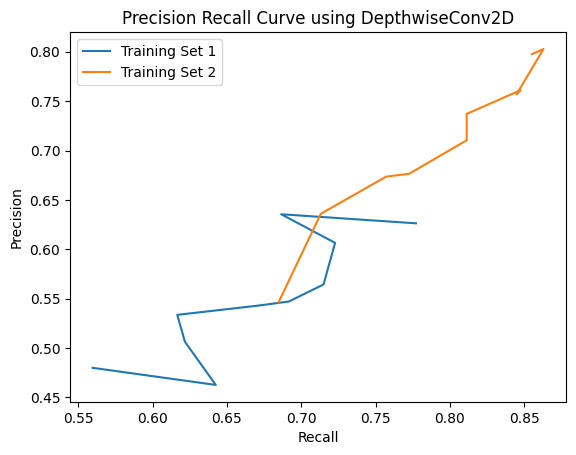

In [82]:
import matplotlib.pyplot as plt
import numpy as np
image_dir = extract_tar(tar_path, extract_path)
csv_data = read_csv()
X_first, y_first, X_second, y_second =split_data('blur')
import time
start_time = time.time()
x1,y1,x2,y2 = make_binary_NN(X_first, y_first, X_second, y_second, image_dir, 'blur')
end_time = time.time()
print(f"Function took {end_time - start_time:.2f} seconds")

plt.plot(x1, y1, label='Training Set 1')
plt.plot(x2, y2, label='Training Set 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve using DepthwiseConv2D')
plt.legend()
plt.show()
